# Условие

Даны два метода генерации случайных перестановок длиной 8.

In [3]:
import random

def RandomPermutation():
    perm = list(range(8))
    random.shuffle(perm)
    return perm

def StupidPermutation():
    partialSums = [0,1,8,35,111,285,
        628,1230,2191,3606,5546,8039,11056,14506,18242,  
        22078,25814,29264,32281,34774,36714,38129,39090,  
        39692,40035,40209,40285,40312,40319,40320]
    r = random.randint(0, partialSums[-1])
    numInv = 0
    while partialSums[numInv] < r:
        numInv += 1
    perm = list(range(8))
    for step in range(numInv):
        t1 = random.randint(0, 7)
        t2 = random.randint(0, 7)
        perm[t1], perm[t2] = perm[t2], perm[t1]
    return perm

Во втором partialSum выбран так, что распределение числа numInv получается правильным. Дальше допущена ошибка, из-за которой перестановки не получаются с одинаковой вероятностью.

Даны n наборов перестановок по 1000 штук. Необходимо для каждого набора определить каким методом он был сгенерирован. В ответ вывести числа от 0 до n-1 - номера наборов перестановок. Сначала должны идти номера хороших наборов, потом творческих. Точность ответа должна быть $\frac{good}{total}\geq 0.98$, где:
- $good$ - количество пар индексов $i<j$ таких, что генератор для набора $i$ "хороший", а для $j$ "творческий";
- $total$ - количество пар индексов $i<j$ таких, что генераторы для наборов $i$ и $j$ различны.

# Решение

Попробуем три подхода к решению. Первые два предлагают решить задачу без анализа кода StupidPermutation.

## Подсчет количества уникальных объектов выборки

Нам сказано, что RandomPermutation выдает равномерное распределение перестановок. Значит даже не глядя на код StupidPermutation можно понять, что второй способ генерации выдает неравномерное.

Всего перестановок $8!=40320$, при этом выборки размером $1000$. Можно сделать предположение, что равномерное распределение будет иметь больше различных перестановок в выборке, чем любое другое. Так оно и есть. Тогда решением будет подсчет количества уникальных перестановок в выборке, а потом сортировка по этому количеству в обратном порядке, чтобы в начале списка оказались наиболее разнообразные выборки.

-----

Такое решение не дало правильный ответ и вот почему. Для выборки в $1000$ объектов при общем числе перестановок $40320$ многие распределения дают близкие количества уникальных объектов. Рассчитаем среднее количество уникальных объектов в выборке.

Пусть
- $N=40320$ - общее количество объектов
- $n=1000$ - объем выборки
- $I_i=\left\{ \begin{array}{l}1 \quad \text{если объект i встретился хотя бы раз в выборке}\\ 0 \quad \text{иначе} \end{array}\right.$.

Тогда число уникальных значений
$$K=\sum \limits_{i=1}^N I_i$$
Среднее значение уникальных значений в выборке равно мат ожиданию $$E[K]=E[\sum \limits_{i=1}^N I_i]=\sum \limits_{i=1}^N E[I_i]=\sum \limits_{i=1}^N P(I_i=1)$$
Вероятность $P(I_i=1)$ того, что объект будет хотя бы раз в выборке, равна единице минус вероятность того, что объект в выборку не попал:
$$P(I_i=1)=1-P(I_i=0)=1-(1-p_i)^n$$
где $p_i$ - вероятность $i$-ого исхода в одной генерации выборки. Тогда среднее количество уникальных объектов в выборке:
$$E[K]=\sum \limits_{i=1}^N P(I_i=1)=\sum \limits_{i=1}^N (1-(1-p_i)^n)$$
Имея эту формулу, можем посчитать, что при равномерном распределении, где $p_i=\frac{1}{40320}$ для всех $i$,
$$E[K]=40320*(1-(1-\frac{1}{40320})^{1000})\approx 987.7$$
Рассмотрим неравномерное распределение, где у $10\%$ объектов (то есть у $0.1*40320=4032$) суммарная вероятность быть в выборке $0.5$, у оставшихся $90\%$ (то есть $0.9*40320=36288$) тогда тоже суммарная вероятность $0.5$. Тогда для первой группы $p_{high}=\frac{0.5}{4032}=\frac{1}{8064}$, для второй $p_{low}=\frac{0.5}{36288}=\frac{1}{72576}$. Среднее количество уникальных объектов в выборке:
$$E[K]=4032*(1-(1-\frac{1}{8064})^{1000})+36288*(1-(1-\frac{1}{72576})^{1000})\approx 966.8$$
Получается, что настолько неравномерное распределение имеет разницу по ожидаемому количеству уникальных объектов в выборке с равномерным $\approx 20.9$. Я не стану расписывать почему этого недостаточно для того, чтобы с с $98\%$ вероятностью разделять выборки по критерию количества уникальных объектов в выборке (для этого читай переписку с чатом, начиная с моего вопроса "Как ты посчитал ожидаемое число уникальных значений?").

Но на самом деле, если посмотреть на входной файл, можно увидеть, что там распределение StupidPermutation куда равномернее, чем приведенное здесь в качестве примера:

In [23]:
fact = [1, 1, 2, 6, 24, 120, 720, 5040, 40320]

def get_perm_num(a):
    num = 0
    for i in range(len(a)):
        less = 0
        for j in range(i):
            if a[j] < a[i]:
                less += 1
        num += (a[i] - less) * fact[len(a) - i - 1]
    return num

f = open('209permutations.in', 'r')
n = int(f.readline())
p = []
for i in range(n):
    perm_unique = set()
    for j in range(1000):
        a = [int(x) for x in f.readline().split()]
        perm_num = get_perm_num(a)
        perm_unique.add(perm_num)
    p.append(len(perm_unique))
f.close()
print('Max count of unique objects in samples:', max(p))
print('Min count of unique objects in samples:', min(p))

Max count of unique objects in samples: 995
Min count of unique objects in samples: 976


## Вычисление энтропии выборки

Пусть у нас есть событие с вероятностью $p$. Тогда количество информации (по-другому, уменьшение неопределенности), полученное в результате этого события будет
$$I(p)=-log_2(p)$$

Минус у логарифма введен, так как функция логарифма растет от $-inf$ до $0$ при увеличении $p$, а смысл функции информации в том, что чем более редкое (невероятное) событие произошло, тем больше информации было получено. Например, $I(p=\frac{1}{2})=-log_2(\frac{1}{2})=1$, а $I(p=\frac{1}{4})=-log_2(\frac{1}{4})=2$.
<br>
В принципе логарифм выбран, так как информация считается аддитивной. Если произошли события с вероятностями $p_1$ и $p_2$ и общей вероятностью $p_1*p_2$, общая полученная информация будет $I(p_1*p_2)=I(p_1)+I(p_2)$. А функция, превращающая умножение в сложение, - это логарифм $log_2(p_1*p_2)=log_2(p_1)+log_2(p_2)$.

Энтропия является мерой средней неопределенности, то есть какое среднее количество информации мы получаем за одно наблюдение. То есть его можно считать как мат ожидание информации:
$$H=\sum\limits_{i=1}^k p_i I(p_i)=\sum\limits_{i=1}^k p_i (-log_2(p_i))=-\sum\limits_{i=1}^k p_i log_2(p_i)$$
где $p_i$ - вероятности всех исходов.

Тогда можно посчитать выборочную энтропию на выборке, где $p_i=\frac{c_i}{n}$ - вероятность получения некоторой перестановки равно количеству встреченных таких перестановок на объем выборки. Если выборка равномерная, мы получим большую энтропию, чем если она неравномерная.
<br>
С энтропией мы учитываем больше информации - не только количество уникальных значений, но и частоту каждого объекта в отдельности на данной выборке.

-----

Однако и такой подход не помогает в решении, так как реализованный StupidPermutation все равно дает близкое к равномерному распределение. Среднее значение получаемой информации не помогает, оно сильно зашумляется подовляющем большинством перестановок, которые встречаются по одному разу. Это можно видеть по графикам.

In [24]:
import numpy as np

perm1 = []
perm2 = []
for i in range(100000):
    perm1.append(get_perm_num(RandomPermutation()))
    perm2.append(get_perm_num(StupidPermutation()))
perm1 = np.array(perm1)
perm2 = np.array(perm2)
u1, c1 = np.unique(perm1, return_counts=True)
u2, c2 = np.unique(perm2, return_counts=True)

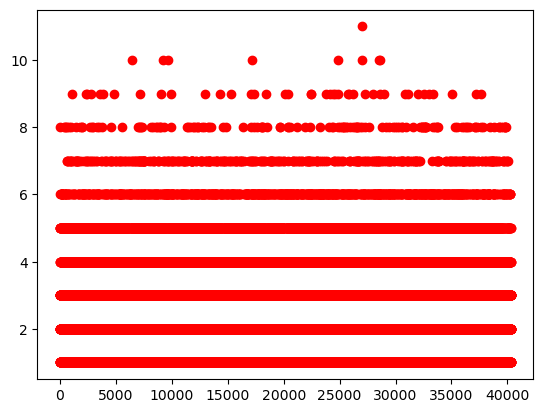

In [25]:
import matplotlib.pyplot as plt

plt.plot(u1, c1, 'ro')

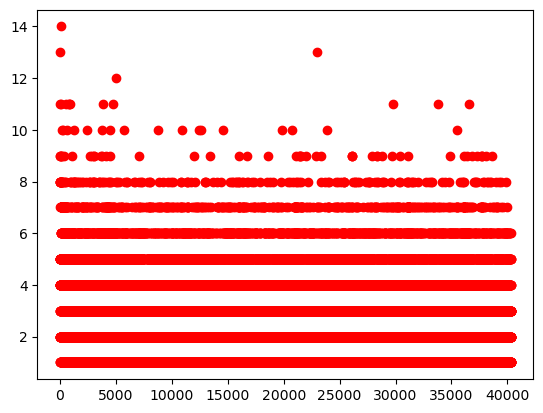

In [26]:
plt.plot(u2, c2, 'ro')

Мы хоть и видим, что при StupidPermutation встречаются перестановки более, чем по 11 раз, но таких очень мало (штуки 4). В данном примере у нас сто тысяч генераций, и на среднее значение такое количество почти не повлияет.

## Анализ StupidPermutation

Даже не зная как писать свою равномерную сортировку, из условия мы знаем, что ошибка допущена в коде уже после задания numInv. Единственное место, которое вызывает сомнения - это перестановка чисел *perm[t1], perm[t2] = perm[t2], perm[t1]*, ведь получается, что иногда, когда $t_1=t_2$ перестановки не происходит.

Это значит, что существуют некоторая вероятность, когда какое-то число останется на своем месте. Посчитаем вероятность для равномерного распределения и для StupidPermutation.

Введем:
- $\pi$ - перестановка, $\pi(i)$ - элемент перестановки
- $I_i=\left\{ \begin{array}{l}1 \quad \text{если $\pi(i)=i$}\\ 0 \quad \text{иначе} \end{array}\right.$
- $X=\sum\limits_{i=0}^7 I_i$ - количество элементов перестановки, оставшихся на месте

Тогда для равномерного распределения на симметрической группе $S_8$ вероятность $i$-ого элемента остаться на месте равно
$$P(I_i=1)=\frac{\text{количество перестановок, когда $\pi(i)=i$}}{\text{общее число перестановок}}=\frac{|\{\pi\in S_8: \pi(i)=i\}|}{|S_8|}=\frac{7!}{8!}=\frac{1}{8}$$
Мат ожидание количества элементов перестановки $X$
$$E[X]=\sum\limits_{i=0}^7 I_i=8*\frac{1}{8}=1$$
Значит в среднем при равномерном распределении на своем месте остается один элемент перестановки, что *кстати* верно для любой длины перестановки, не только 8.

Среднее число элементов, остающихся на своих местах при StupidPermutation точно больше 1. Интуитивно это можно понять так, что будучи почти равномерным распределением, StupidPermutation стремится к нему при бесконечно большом количестве свопов, то есть стремится к ситуации, когда на своих местах будет оставаться один элемент. Пока свопов мало, больше шанс, что $t_1=t_2$ будет возникать, а вновь выпадать тот же $t_1$ не будет успевать.

*Строгое доказательство использует цепи Маркова, это новая для меня тема, так что для полного разбирания надо читать чат.*

# Код

In [18]:
f = open('209permutations.in', 'r')
n = int(f.readline())
p = []
for i in range(n):
    fixed_points = 0
    for j in range(1000):
        a = [int(x) for x in f.readline().split()]
        fixed_points += sum(a[i] == i for i in range(8))
    p.append((fixed_points / 1000, i))
f.close()
p.sort()
f = open('209permutations.txt', 'w')
for i in range(n):
    f.write(str(p[i][1]) + '\n')
    print(p[i][0], p[i][1])
f.close()

0.927 88
0.933 164
0.947 172
0.948 66
0.949 162
0.952 184
0.953 14
0.956 31
0.956 183
0.957 150
0.961 81
0.962 74
0.963 60
0.963 106
0.963 114
0.966 113
0.967 6
0.968 193
0.97 32
0.976 67
0.976 186
0.977 137
0.978 91
0.978 167
0.979 190
0.981 120
0.983 125
0.984 157
0.985 33
0.985 140
0.987 92
0.987 115
0.987 199
0.988 29
0.989 48
0.989 104
0.989 170
0.99 131
0.99 134
0.991 41
0.991 70
0.992 55
0.992 174
0.993 43
0.996 119
0.998 3
1.002 2
1.002 82
1.002 145
1.003 147
1.004 50
1.004 189
1.007 110
1.007 144
1.008 26
1.009 42
1.009 117
1.009 176
1.011 90
1.015 132
1.016 15
1.016 62
1.017 168
1.017 192
1.019 18
1.021 51
1.022 0
1.023 63
1.025 39
1.025 47
1.025 53
1.028 17
1.028 57
1.032 5
1.032 173
1.032 179
1.033 149
1.033 152
1.034 79
1.035 64
1.035 141
1.036 71
1.037 4
1.037 158
1.038 197
1.039 19
1.039 44
1.039 136
1.042 10
1.044 161
1.046 139
1.052 34
1.056 126
1.058 96
1.059 37
1.059 118
1.059 151
1.06 68
1.062 111
1.085 187
1.101 16
1.104 185
1.107 121
1.117 153
1.123 25
1.13 94
1.1